### Clustering and Classification

Code to cluster and classify code for "Natural Language Processing and Computational Linguistics".
Lets use two different corpuses to play around with the data. 

### Imports

In [1]:
# data imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# clustering imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans

# classification imports
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [2]:
# general imports
import logging
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# warnings imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 20 NG dataset

In [3]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

In [4]:
data_train = fetch_20newsgroups(subset='train', categories=categories,
                             shuffle=True, random_state=42)

In [5]:
labels = data_train.target
true_k = np.unique(labels).shape[0]

In [6]:
print("%d documents" % len(data_train.data))
print("%d categories" % len(data_train.target_names))

2034 documents
4 categories


### Visualising Dataset

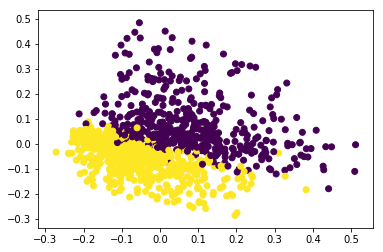

In [7]:
from sklearn.decomposition import PCA


newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=['alt.atheism', 'sci.space'])
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(newsgroups_train.data).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=newsgroups_train.target)

### Vectorizing

In [8]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)

In [9]:
X_train = vectorizer.fit_transform(data_train.data)

In [10]:
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 2034, n_features: 17259


### Dimensionality Reduction

In [11]:
n_components = 5

In [12]:
# Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_train = lsa.fit_transform(X_train)

### Clustering

We'll start with clustering, and experiment with both k-means and heirarchial clustering.

#### K-means

In [13]:
minibatch = True

In [14]:
if minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1, init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
km.fit(X_train)

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [15]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train, km.labels_, sample_size=1000))

Homogeneity: 0.616
Completeness: 0.653
V-measure: 0.634
Adjusted Rand-Index: 0.633
Silhouette Coefficient: 0.472


In [16]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [17]:
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 keith
 caltech
 sgi
 livesey
 morality
 wpd
 solntze
 com
 objective
 jon
Cluster 1:
 space
 nasa
 henry
 toronto
 alaska
 gov
 com
 access
 moon
 article
Cluster 2:
 god
 people
 jesus
 com
 don
 say
 bible
 believe
 think
 just
Cluster 3:
 graphics
 space
 com
 nasa
 university
 image
 posting
 files
 host
 thanks


### Heirarchial Clustering

To do heirarchial clustering we need pairwise distances.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X_train)

In [19]:
from scipy.cluster.hierarchy import ward, dendrogram

In [20]:
# titles = ?

In [21]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

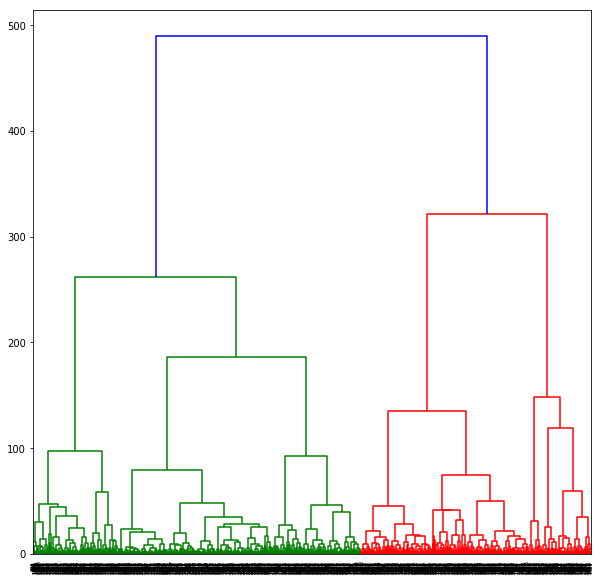

In [22]:
fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax = dendrogram(linkage_matrix)

### Classification

#### Data

In [23]:
# order of labels in `target_names` can be different from `categories`
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42)

target_names = data_train.target_names

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(data_test.data)
X_test = lsa.fit_transform(X_test)

Extracting features from the test data using the same vectorizer


### Classification

In [24]:
from sklearn.naive_bayes import GaussianNB

In [25]:
gnb = GaussianNB()
y_pred_NB = gnb.fit(X_train, y_train).predict(X_test)

In [26]:
from sklearn.svm import SVC

In [27]:
svm = SVC()
y_pred_SVM = svm.fit(X_train, y_train).predict(X_test) 

### Classification Report

The precision is the percentage of the test samples that were classified to the category and actually belonged to the category.

The recall is the percentage of all the test samples that originally belonged to the category and in the evaluation process were correctly classified to the category

In [28]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_test, y_pred_NB))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       319
          1       0.00      0.00      0.00       389
          2       0.00      0.00      0.00       394
          3       0.10      0.27      0.14       251

avg / total       0.02      0.05      0.03      1353



In [30]:
np.mean(y_pred_SVM == y_test)

0.038433111603843315

In [31]:
y_test

array([2, 1, 1, ..., 3, 1, 1])

In [32]:
y_pred_NB

array([0, 3, 3, ..., 3, 3, 3])